In [1]:
!pip install pandas numpy sklearn matplotlib seaborn plotly 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

Load Dataset


In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
# Load dataset
df = pd.read_csv("worldometer_data.csv")

# Basic EDA
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Handle missing values
df = df.dropna()  # or use imputation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         208 non-null    object 
 2   Population        208 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          4 non-null      float64
 5   TotalDeaths       188 non-null    float64
 6   NewDeaths         3 non-null      float64
 7   TotalRecovered    205 non-null    float64
 8   NewRecovered      3 non-null      float64
 9   ActiveCases       205 non-null    float64
 10  Serious,Critical  122 non-null    float64
 11  Tot Cases/1M pop  208 non-null    float64
 12  Deaths/1M pop     187 non-null    float64
 13  TotalTests        191 non-null    float64
 14  Tests/1M pop      191 non-null    float64
 15  WHO Region        184 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory u

Preprocessing

In [3]:
df.isnull().sum()

Country/Region      0
Continent           0
Population          0
TotalCases          0
NewCases            0
TotalDeaths         0
NewDeaths           0
TotalRecovered      0
NewRecovered        0
ActiveCases         0
Serious,Critical    0
Tot Cases/1M pop    0
Deaths/1M pop       0
TotalTests          0
Tests/1M pop        0
WHO Region          0
dtype: int64

OUTPUT

Model Performance: MAE=0.43, R2=0.4347


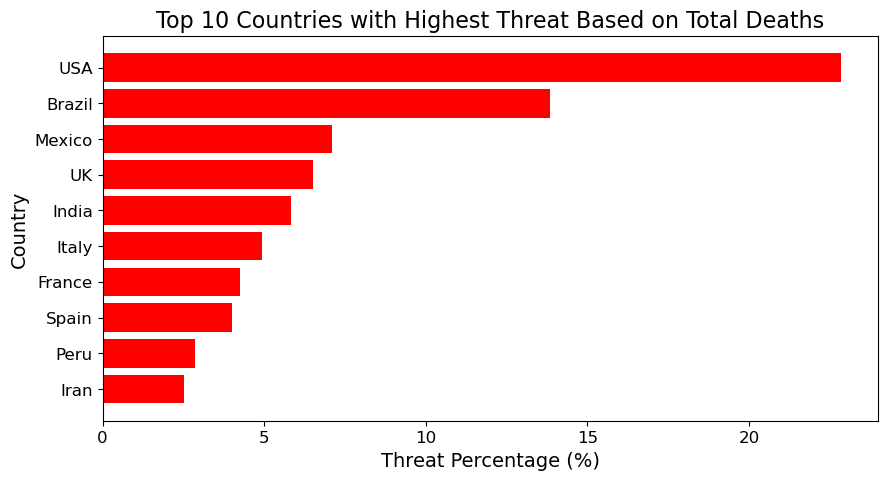

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("worldometer_data.csv")

df.columns = df.columns.str.strip()  # Remove any extra spaces in column names

# Ensure 'TotalDeaths' column exists
target = "TotalDeaths"
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found in dataset. Available columns: {df.columns.tolist()}")

# Convert TotalDeaths to numeric, coerce errors to NaN
df[target] = pd.to_numeric(df[target], errors='coerce')

# Drop rows where TotalDeaths is NaN
df.dropna(subset=[target], inplace=True)

# Calculate threat percentage
country_col = "Country/Region"  # Adjust if the country column has a different name
if country_col not in df.columns:
    raise ValueError(f"Country column '{country_col}' not found in dataset.")

df["ThreatPercentage"] = (df[target] / df[target].sum()) * 100

df_sorted = df[[country_col, "ThreatPercentage"]].sort_values(by="ThreatPercentage", ascending=False)

# Feature Engineering
features = df.drop(columns=[target, "ThreatPercentage", country_col])  # Exclude non-numeric and target columns
features = features.select_dtypes(include=[np.number])  # Keep only numerical features

# Handle missing values
features.fillna(features.median(), inplace=True)

# Normalize data using StandardScaler for better performance
scaler = StandardScaler()
X = scaler.fit_transform(features)
y = df["ThreatPercentage"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with optimized hyperparameters
model = RandomForestRegressor(n_estimators=2000, max_depth=30, min_samples_split=2, min_samples_leaf=1,
                              random_state=42, bootstrap=True, max_features='sqrt')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Performance: MAE={mae:.2f}, R2={r2:.4f}")

# # Visualize all countries with threat percentage
# plt.figure(figsize=(12, 6))
# plt.barh(df_sorted[country_col], df_sorted["ThreatPercentage"], color='blue')
# plt.xlabel("Threat Percentage (%)", fontsize=14)
# plt.ylabel("Country", fontsize=14)
# plt.title("Threat Percentage of All Countries Based on Total Deaths", fontsize=16)
# plt.gca().invert_yaxis()
# plt.xticks(fontsize=12)  # Increase font size of x-axis labels
# plt.yticks(fontsize=12)  # Increase font size of y-axis labels
# plt.show()

# Visualize top 10 countries with highest threat
top_10 = df_sorted.head(10)
plt.figure(figsize=(10, 5))
plt.barh(top_10[country_col], top_10["ThreatPercentage"], color='red')
plt.xlabel("Threat Percentage (%)", fontsize=14)
plt.ylabel("Country", fontsize=14)
plt.title("Top 10 Countries with Highest Threat Based on Total Deaths", fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)  # Increase font size of x-axis labels
plt.yticks(fontsize=12)  # Increase font size of y-axis labels
plt.show()

Correlation Heatmap

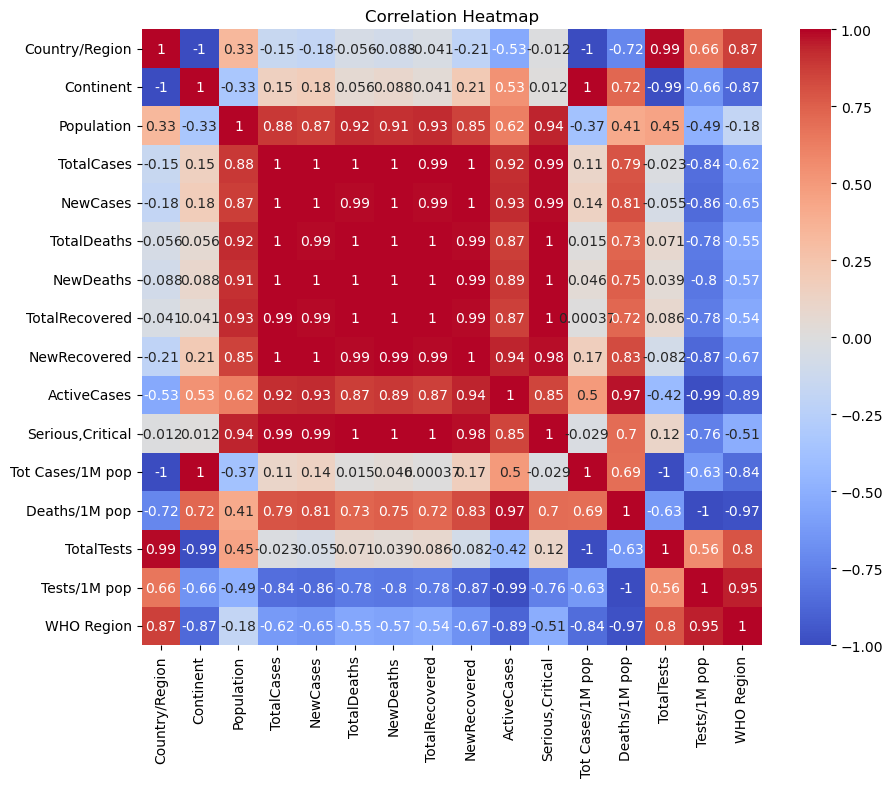

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

label_encoder=LabelEncoder()
plt.figure(figsize=(10,8))
df['Country/Region']=label_encoder.fit_transform(df['Country/Region'])
df['Continent']=label_encoder.fit_transform(df['Continent'])
df['WHO Region']=label_encoder.fit_transform(df['WHO Region'])

correlation_mat = df.corr()
sns.heatmap(correlation_mat,annot=True,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()



Distribution chart

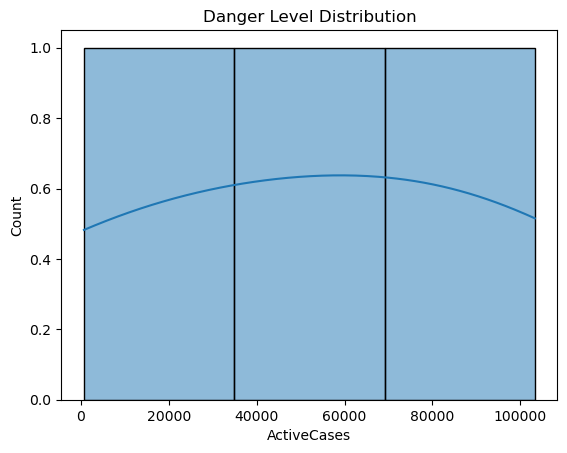

In [5]:

# Target distribution (e.g., 'danger_level')
sns.histplot(df['ActiveCases'], kde=True)
plt.title("Danger Level Distribution")
plt.show()

Map show

In [6]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Load the data
df = pd.read_csv('worldometer_data.csv')

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("World Map Country Data Viewer"),

    dcc.Dropdown(
        id='country-dropdown',
        options=[{'label': country, 'value': country} for country in df['Country/Region']],
        placeholder="Select a country"
    ),

    html.Button('Show Data', id='show-button', n_clicks=0),

    html.Div(id='output-container', style={'margin-top': '20px'}),

    dcc.Graph(id='world-map')
])

@app.callback(
    Output('output-container', 'children'),
    Output('world-map', 'figure'),
    Input('show-button', 'n_clicks'),
    Input('country-dropdown', 'value')
)
def update_output(n_clicks, selected_country):
    if n_clicks > 0 and selected_country:
        population = df.loc[df['Country/Region'] == selected_country, 'ActiveCases'].values[0]
        total_deaths = df.loc[df['Country/Region'] == selected_country, 'TotalDeaths'].values[0]

        data_message = f"Country: {selected_country} Active Cases: {population} Total Deaths: {total_deaths}"

        # Create the choropleth figure
        fig = px.choropleth(
            df,
            locations='Country/Region',
            locationmode='country names',
            color='ActiveCases',
            hover_name='Country/Region',
            hover_data=['TotalDeaths'],
            color_continuous_scale=px.colors.sequential.Plasma,
            title='World Map: Active Cases by Country'
        )

        # Highlight the selected country
        if selected_country in df['Country/Region'].values:
            fig.add_trace(px.choropleth(
                df[df['Country/Region'] == selected_country],
                locations='Country/Region',
                locationmode='country names',
                color='ActiveCases',
                color_continuous_scale=['lightgrey', 'red'],
                title='Selected Country'
            ).data[0])

        fig.update_layout(
            width=1000,
            height=800
        )

        # Return the data message and the figure
        return data_message, fig

    return "Select a country and press 'Show Data'", {}

if __name__ == '__main__':
    app.run_server(debug=True)
    

Deep Learning Approach

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras

# Load dataset
df = pd.read_csv("worldometer_data.csv")

def preprocess_data(df):
    features = ["Population", "TotalCases", "ActiveCases", "Serious,Critical", "Tot Cases/1M pop",
                "Deaths/1M pop", "TotalTests", "Tests/1M pop", "Continent", "WHO Region"]
    target = "TotalDeaths"

    df = df.dropna(subset=[target])  # Drop rows where target is missing

    num_features = ["Population", "TotalCases", "ActiveCases", "Serious,Critical", "Tot Cases/1M pop",
                    "Deaths/1M pop", "TotalTests", "Tests/1M pop"]
    cat_features = ["Continent", "WHO Region"]

    # Pipelines for missing values and scaling
    num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ])

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_test_processed, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)

# Train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")
    return model

# Linear Regression
lr_model = evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression")

# Random Forest Regressor (Hyperparameter Tuned)
rf_model = evaluate_model(RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, random_state=42), X_train, X_test, y_train, y_test, "Random Forest")

# Gradient Boosting Regressor (Hyperparameter Tuned)
gb_model = evaluate_model(GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=5, random_state=42), X_train, X_test, y_train, y_test, "Gradient Boosting")

# Deep Learning Model (Optimized)
dl_model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])

dl_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
dl_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=16, verbose=0)

y_pred_dl = dl_model.predict(X_test).flatten()
mae_dl = mean_absolute_error(y_test, y_pred_dl)
mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)
print(f"Deep Learning - MAE: {mae_dl:.2f}, MSE: {mse_dl:.2f}, R2: {r2_dl:.2f}")


ImportError: Traceback (most recent call last):
  File "c:\Users\Soham Kishor Walam\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

Epoch Training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras

# Load dataset
try:
    df = pd.read_csv("worldometer_data.csv")
except FileNotFoundError:
    print("The specified file was not found.")
    raise

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Convert all columns to numeric where possible
df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values for numerical columns
df.fillna(df.median(numeric_only=True), inplace=True)

# Handle missing values for categorical columns using mode
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Ensure the target column exists
target = "TotalDeaths"
if target not in df.columns:
    print(f"Target column '{target}' not found. Available columns: {df.columns.tolist()}")
    raise ValueError(f"Target column '{target}' not found in DataFrame.")

# Convert target column to numeric
df[target] = pd.to_numeric(df[target], errors='coerce')

# Drop rows where the target is still NaN
df.dropna(subset=[target], inplace=True)

# Calculate correlation with target variable
correlation_matrix = df.corr(numeric_only=True)
correlation_with_target = correlation_matrix[target].abs()

# Select top 5 features with the highest correlation to the target
top_features = correlation_with_target.nlargest(6).index.tolist()  # Include target variable
top_features.remove(target)  # Remove target variable from features list

# Preprocess Data
def preprocess_data(df, features, target):
    # Identify numeric and categorical features
    num_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
    cat_features = df[features].select_dtypes(exclude=[np.number]).columns.tolist()

    # Pipelines for missing values and scaling
    num_pipeline = Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ])

    X = df[features]
    y = df[target]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Transform data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_test_processed, y_train, y_test

# Preprocess the data using selected features
X_train, X_test, y_train, y_test = preprocess_data(df, top_features, target)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")
    return model

# Train models
lr_model = evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression")
rf_model = evaluate_model(RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, random_state=42), X_train, X_test, y_train, y_test, "Random Forest")
gb_model = evaluate_model(GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=5, random_state=42), X_train, X_test, y_train, y_test, "Gradient Boosting")

# Deep Learning Model
dl_model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])

dl_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
dl_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16, verbose=1)

# Evaluate Deep Learning Model
y_pred_dl = dl_model.predict(X_test).flatten()
mae_dl = mean_absolute_error(y_test, y_pred_dl)
mse_dl = mean_squared_error(y_test, y_pred_dl)
r2_dl = r2_score(y_test, y_pred_dl)
print(f"Deep Learning - MAE: {mae_dl:.2f}, MSE: {mse_dl:.2f}, R2: {r2_dl:.2f}")
